***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet\Training_and_Analysis\5_CU_BIRD
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "4" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  4
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Parameters

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 16,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": 'adam',
                "loss_function": models.MarginLoss(),
               }

# Import Dataset : CU BIRD

In [5]:
training_dataset,  test_dataset, val_dataset, tree, info = datasets.CU_Birds_200_2011(image_size=(64, 64), 
                                                                                  batch_size=train_params['batch_size'],
                                                                                  data_aug = 'mixup', # 'mixup'
                                                                                  data_normalizing = None) #'normalize'

In [6]:
for x,y in training_dataset.take(1):
    image_shape = x.shape[1:]
    coarse_label_shape = y[0].shape[1:]
    medium_label_shape = y[1].shape[1:]
    fine_label_shape = y[2].shape[1:]

In [7]:
## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": info['Num_Coarse'],
                         "medium": info['Num_Medium'],
                         "fine": info['Num_Fine']})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

## Learning Rate Decay Scheduler

In [8]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

## Model Architecture

# Bottom up Approach

## Loss Function

In [9]:
Matrix_coarse_to_medium_OneHot = tf.constant(info['Matrix_coarse_to_medium'], dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(info['Matrix_medium_to_fine'], dtype=tf.float32)

In [10]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,
               number_of_classes_m, number_of_classes_f, C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=number_of_classes_m)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=number_of_classes_f)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Architecture

In [11]:
def get_compiled_model():
    input_shape = image_shape

    input_shape_yc = coarse_label_shape
    input_shape_ym = medium_label_shape
    input_shape_yf = fine_label_shape

    no_coarse_class = info['Num_Coarse']
    no_medium_class = info['Num_Medium']
    no_fine_class = info['Num_Fine']

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 16
    SCap_c_dims = 16


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    # input [batch_size, 6, 6, 512], output [batch_size, 2304, 8]

    reshape = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims), PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshape)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(p_caps)

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_f)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(
        inputs= [x_input, y_c, y_m, y_f],
        outputs= [pred_c, pred_m, pred_f],
        name='HD-CapsNet')
    
    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw'],
                             info['Num_Medium'],info['Num_Fine']))
    
    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
                 )
    return model

## Compile Model

In [12]:
model = get_compiled_model()

## log directory

In [13]:
directory = sysenv.log_dir('5_CU_BIRD/HD_CapsNet/W_C_loss')

FOLDER CREATED =  ../../logs/5_CU_BIRD/HD_CapsNet/W_C_loss


In [14]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.cast (TFOpLambda)           (None,)              0           ['tf.math.argmax_4[0][0]']       
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 1)            0           ['tf.math.reduce_sum_2[0][0]']   
                                                                                                  
 tf.math.argmax (TFOpLambda)    (None,)              0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.argmax_1 (TFOpLambda)  (None,)              0           ['prediction_medium[0][0]']      
                                                                                                  
 tf.math.argmax_5 (TFOpLambda)  (None,)              0           ['input_ym[0][0]']               
          

 da)                                                                                              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.multiply[0][0]']       
 )                                                                                                
                                                                                                  
 tf.math.maximum_4 (TFOpLambda)  (None, 200)         0           ['tf.math.subtract_10[0][0]']    
                                                                                                  
 tf.math.subtract_12 (TFOpLambd  (None, 200)         0           ['input_yf[0][0]']               
 a)                                                                                               
                                                                                                  
 tf.math.m

                                                                                                  
 tf.math.multiply_4 (TFOpLambda  (None,)             0           ['tf.math.abs_2[0][0]',          
 )                                                                'tf.math.abs[0][0]']            
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 200)          0           ['tf.math.multiply_16[0][0]',    
                                                                  'tf.math.multiply_18[0][0]']    
                                                                                                  
 tf.math.abs_3 (TFOpLambda)     (None,)              0           ['tf.math.subtract_3[0][0]']     
                                                                                                  
 tf.math.abs_1 (TFOpLambda)     (None,)              0           ['tf.math.subtract_1[0][0]']     
          

## Data Augmentation

## Training Pipeline Alignment

In [15]:
#### Matching the pipeling with model inputs
def pipeline_multi_input_output(image, label):
    label_0 = label[0]
    label_1 = label[1]
    label_2 = label[2]
    return (image, label_0, label_1, label_2), (label_0, label_1, label_2)
### matchin X,Y with model input
training_dataset_match = training_dataset.map(pipeline_multi_input_output) ## Mixup dataset
val_dataset_match = val_dataset.map(pipeline_multi_input_output) ## Val Dataset

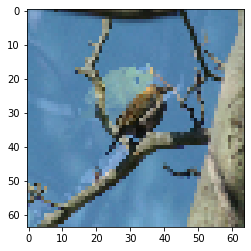

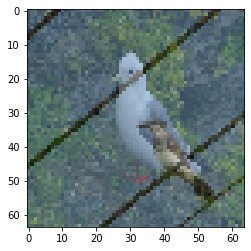

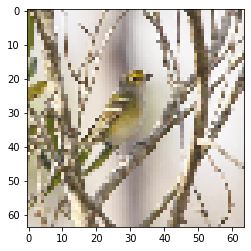

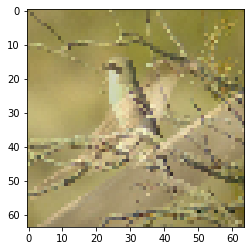

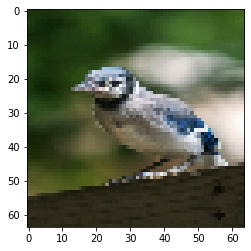

In [16]:
for x,y in training_dataset_match.take(5):
    plt.imshow(x[0][0])
    plt.show()
    

## Callback

In [17]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [18]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_dataset_match,
                        epochs = train_params["n_epochs"],
                        validation_data = val_dataset_match,
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
375/375 [==============================] - ETA: 0s - loss: 0.8055 - prediction_coarse_accuracy: 0.0062 - prediction_medium_accuracy: 0.0204 - prediction_fine_accuracy: 0.0175
  • Coarse Accuracy = 0.62% | Val_Accuracy = 1.14% | LossWeight = 0.45 
  • Medium Accuracy = 2.04% | Val_Accuracy = 6.66% | LossWeight = 0.33 
  • Fine   Accuracy = 1.75% | Val_Accuracy = 2.11% | LossWeight = 0.22 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.02106, saving model to ../../logs/5_CU_BIRD/HD_CapsNet/W_C_loss\epoch-best.h5
375/375 [==============================] - 168s 390ms/step - loss: 0.8055 - prediction_coarse_accuracy: 0.0062 - prediction_medium_accuracy: 0.0204 - prediction_fine_accuracy: 0.0175 - val_loss: 0.7922 - val_prediction_coarse_accuracy: 0.0114 - val_prediction_medium_accuracy: 0.0666 - val_prediction_fine_accuracy: 0.0211 - lr: 0.0010
Epoch 2/100
375/375 [==============================] - ETA: 0s - loss: 0.7681 - prediction_coarse_accuracy: 0.0490 - pre

375/375 [==============================] - 159s 401ms/step - loss: 0.5212 - prediction_coarse_accuracy: 0.3238 - prediction_medium_accuracy: 0.1607 - prediction_fine_accuracy: 0.4751 - val_loss: 0.5492 - val_prediction_coarse_accuracy: 0.3183 - val_prediction_medium_accuracy: 0.1460 - val_prediction_fine_accuracy: 0.1111 - lr: 0.0010
Epoch 10/100
375/375 [==============================] - ETA: 0s - loss: 0.5101 - prediction_coarse_accuracy: 0.3632 - prediction_medium_accuracy: 0.1962 - prediction_fine_accuracy: 0.5609
  • Coarse Accuracy = 36.32% | Val_Accuracy = 32.17% | LossWeight = 0.44 
  • Medium Accuracy = 19.62% | Val_Accuracy = 15.67% | LossWeight = 0.41 
  • Fine   Accuracy = 56.09% | Val_Accuracy = 11.81% | LossWeight = 0.15 

Epoch 10: val_prediction_fine_accuracy improved from 0.11115 to 0.11805, saving model to ../../logs/5_CU_BIRD/HD_CapsNet/W_C_loss\epoch-best.h5
375/375 [==============================] - 159s 403ms/step - loss: 0.5101 - prediction_coarse_accuracy: 0.363

Epoch 19/100
375/375 [==============================] - ETA: 0s - loss: 0.3103 - prediction_coarse_accuracy: 0.6979 - prediction_medium_accuracy: 0.5681 - prediction_fine_accuracy: 0.9127
  • Coarse Accuracy = 69.79% | Val_Accuracy = 38.73% | LossWeight = 0.45 
  • Medium Accuracy = 56.81% | Val_Accuracy = 21.88% | LossWeight = 0.48 
  • Fine   Accuracy = 91.27% | Val_Accuracy = 14.22% | LossWeight = 0.07 

Epoch 19: val_prediction_fine_accuracy improved from 0.14014 to 0.14222, saving model to ../../logs/5_CU_BIRD/HD_CapsNet/W_C_loss\epoch-best.h5
375/375 [==============================] - 158s 404ms/step - loss: 0.3103 - prediction_coarse_accuracy: 0.6979 - prediction_medium_accuracy: 0.5681 - prediction_fine_accuracy: 0.9127 - val_loss: 0.5342 - val_prediction_coarse_accuracy: 0.3873 - val_prediction_medium_accuracy: 0.2188 - val_prediction_fine_accuracy: 0.1422 - lr: 6.3025e-04
Epoch 20/100
375/375 [==============================] - ETA: 0s - loss: 0.2963 - prediction_coarse_accura

375/375 [==============================] - 158s 400ms/step - loss: 0.1876 - prediction_coarse_accuracy: 0.8750 - prediction_medium_accuracy: 0.7828 - prediction_fine_accuracy: 0.9526 - val_loss: 0.5325 - val_prediction_coarse_accuracy: 0.3932 - val_prediction_medium_accuracy: 0.2185 - val_prediction_fine_accuracy: 0.1474 - lr: 3.9721e-04
Epoch 29/100
375/375 [==============================] - ETA: 0s - loss: 0.1747 - prediction_coarse_accuracy: 0.8871 - prediction_medium_accuracy: 0.7905 - prediction_fine_accuracy: 0.9543
  • Coarse Accuracy = 88.71% | Val_Accuracy = 39.80% | LossWeight = 0.39 
  • Medium Accuracy = 79.05% | Val_Accuracy = 22.02% | LossWeight = 0.53 
  • Fine   Accuracy = 95.43% | Val_Accuracy = 14.43% | LossWeight = 0.08 

Epoch 29: val_prediction_fine_accuracy did not improve from 0.14774
375/375 [==============================] - 158s 400ms/step - loss: 0.1747 - prediction_coarse_accuracy: 0.8871 - prediction_medium_accuracy: 0.7905 - prediction_fine_accuracy: 0.954

375/375 [==============================] - ETA: 0s - loss: 0.1303 - prediction_coarse_accuracy: 0.9331 - prediction_medium_accuracy: 0.8864 - prediction_fine_accuracy: 0.9603
  • Coarse Accuracy = 93.31% | Val_Accuracy = 40.39% | LossWeight = 0.39 
  • Medium Accuracy = 88.64% | Val_Accuracy = 23.33% | LossWeight = 0.49 
  • Fine   Accuracy = 96.03% | Val_Accuracy = 14.33% | LossWeight = 0.12 

Epoch 38: val_prediction_fine_accuracy did not improve from 0.15050
375/375 [==============================] - 157s 397ms/step - loss: 0.1303 - prediction_coarse_accuracy: 0.9331 - prediction_medium_accuracy: 0.8864 - prediction_fine_accuracy: 0.9603 - val_loss: 0.5269 - val_prediction_coarse_accuracy: 0.4039 - val_prediction_medium_accuracy: 0.2333 - val_prediction_fine_accuracy: 0.1433 - lr: 2.3783e-04
Epoch 39/100
375/375 [==============================] - ETA: 0s - loss: 0.1266 - prediction_coarse_accuracy: 0.9394 - prediction_medium_accuracy: 0.8901 - prediction_fine_accuracy: 0.9628
  • Co

375/375 [==============================] - 158s 399ms/step - loss: 0.1093 - prediction_coarse_accuracy: 0.9543 - prediction_medium_accuracy: 0.9209 - prediction_fine_accuracy: 0.9656 - val_loss: 0.5178 - val_prediction_coarse_accuracy: 0.3939 - val_prediction_medium_accuracy: 0.2306 - val_prediction_fine_accuracy: 0.1450 - lr: 1.4989e-04
Epoch 48/100
375/375 [==============================] - ETA: 0s - loss: 0.1076 - prediction_coarse_accuracy: 0.9556 - prediction_medium_accuracy: 0.9266 - prediction_fine_accuracy: 0.9683
  • Coarse Accuracy = 95.56% | Val_Accuracy = 39.90% | LossWeight = 0.39 
  • Medium Accuracy = 92.66% | Val_Accuracy = 23.20% | LossWeight = 0.47 
  • Fine   Accuracy = 96.83% | Val_Accuracy = 14.43% | LossWeight = 0.14 

Epoch 48: val_prediction_fine_accuracy did not improve from 0.15050
375/375 [==============================] - 157s 398ms/step - loss: 0.1076 - prediction_coarse_accuracy: 0.9556 - prediction_medium_accuracy: 0.9266 - prediction_fine_accuracy: 0.968

375/375 [==============================] - ETA: 0s - loss: 0.1024 - prediction_coarse_accuracy: 0.9641 - prediction_medium_accuracy: 0.9503 - prediction_fine_accuracy: 0.9726
  • Coarse Accuracy = 96.41% | Val_Accuracy = 39.56% | LossWeight = 0.42 
  • Medium Accuracy = 95.03% | Val_Accuracy = 22.64% | LossWeight = 0.43 
  • Fine   Accuracy = 97.26% | Val_Accuracy = 14.39% | LossWeight = 0.16 

Epoch 57: val_prediction_fine_accuracy did not improve from 0.15050
375/375 [==============================] - 156s 397ms/step - loss: 0.1024 - prediction_coarse_accuracy: 0.9641 - prediction_medium_accuracy: 0.9503 - prediction_fine_accuracy: 0.9726 - val_loss: 0.5360 - val_prediction_coarse_accuracy: 0.3956 - val_prediction_medium_accuracy: 0.2264 - val_prediction_fine_accuracy: 0.1439 - lr: 8.9745e-05
Epoch 58/100
375/375 [==============================] - ETA: 0s - loss: 0.1012 - prediction_coarse_accuracy: 0.9636 - prediction_medium_accuracy: 0.9516 - prediction_fine_accuracy: 0.9716
  • Co

375/375 [==============================] - 158s 400ms/step - loss: 0.1027 - prediction_coarse_accuracy: 0.9606 - prediction_medium_accuracy: 0.9483 - prediction_fine_accuracy: 0.9668 - val_loss: 0.5461 - val_prediction_coarse_accuracy: 0.3939 - val_prediction_medium_accuracy: 0.2237 - val_prediction_fine_accuracy: 0.1477 - lr: 5.6562e-05
Epoch 67/100
375/375 [==============================] - ETA: 0s - loss: 0.0999 - prediction_coarse_accuracy: 0.9616 - prediction_medium_accuracy: 0.9521 - prediction_fine_accuracy: 0.9693
  • Coarse Accuracy = 96.16% | Val_Accuracy = 39.25% | LossWeight = 0.43 
  • Medium Accuracy = 95.21% | Val_Accuracy = 22.33% | LossWeight = 0.40 
  • Fine   Accuracy = 96.93% | Val_Accuracy = 14.67% | LossWeight = 0.17 

Epoch 67: val_prediction_fine_accuracy did not improve from 0.15050
375/375 [==============================] - 158s 399ms/step - loss: 0.0999 - prediction_coarse_accuracy: 0.9616 - prediction_medium_accuracy: 0.9521 - prediction_fine_accuracy: 0.969

375/375 [==============================] - ETA: 0s - loss: 0.1008 - prediction_coarse_accuracy: 0.9666 - prediction_medium_accuracy: 0.9560 - prediction_fine_accuracy: 0.9708
  • Coarse Accuracy = 96.66% | Val_Accuracy = 38.59% | LossWeight = 0.41 
  • Medium Accuracy = 95.60% | Val_Accuracy = 22.30% | LossWeight = 0.40 
  • Fine   Accuracy = 97.08% | Val_Accuracy = 14.81% | LossWeight = 0.18 

Epoch 76: val_prediction_fine_accuracy did not improve from 0.15050
375/375 [==============================] - 158s 400ms/step - loss: 0.1008 - prediction_coarse_accuracy: 0.9666 - prediction_medium_accuracy: 0.9560 - prediction_fine_accuracy: 0.9708 - val_loss: 0.5515 - val_prediction_coarse_accuracy: 0.3859 - val_prediction_medium_accuracy: 0.2230 - val_prediction_fine_accuracy: 0.1481 - lr: 3.3866e-05
Epoch 77/100
375/375 [==============================] - ETA: 0s - loss: 0.0986 - prediction_coarse_accuracy: 0.9633 - prediction_medium_accuracy: 0.9546 - prediction_fine_accuracy: 0.9698
  • Co

375/375 [==============================] - 159s 402ms/step - loss: 0.0970 - prediction_coarse_accuracy: 0.9630 - prediction_medium_accuracy: 0.9523 - prediction_fine_accuracy: 0.9671 - val_loss: 0.5438 - val_prediction_coarse_accuracy: 0.3914 - val_prediction_medium_accuracy: 0.2195 - val_prediction_fine_accuracy: 0.1419 - lr: 2.1344e-05
Epoch 86/100
375/375 [==============================] - ETA: 0s - loss: 0.0978 - prediction_coarse_accuracy: 0.9628 - prediction_medium_accuracy: 0.9538 - prediction_fine_accuracy: 0.9661
  • Coarse Accuracy = 96.28% | Val_Accuracy = 38.97% | LossWeight = 0.42 
  • Medium Accuracy = 95.38% | Val_Accuracy = 22.13% | LossWeight = 0.39 
  • Fine   Accuracy = 96.61% | Val_Accuracy = 14.60% | LossWeight = 0.19 

Epoch 86: val_prediction_fine_accuracy did not improve from 0.15050
375/375 [==============================] - 158s 401ms/step - loss: 0.0978 - prediction_coarse_accuracy: 0.9628 - prediction_medium_accuracy: 0.9538 - prediction_fine_accuracy: 0.966

375/375 [==============================] - ETA: 0s - loss: 0.0937 - prediction_coarse_accuracy: 0.9658 - prediction_medium_accuracy: 0.9546 - prediction_fine_accuracy: 0.9708
  • Coarse Accuracy = 96.58% | Val_Accuracy = 39.14% | LossWeight = 0.41 
  • Medium Accuracy = 95.46% | Val_Accuracy = 22.26% | LossWeight = 0.41 
  • Fine   Accuracy = 97.08% | Val_Accuracy = 14.33% | LossWeight = 0.18 

Epoch 95: val_prediction_fine_accuracy did not improve from 0.15050
375/375 [==============================] - 159s 400ms/step - loss: 0.0937 - prediction_coarse_accuracy: 0.9658 - prediction_medium_accuracy: 0.9546 - prediction_fine_accuracy: 0.9708 - val_loss: 0.5296 - val_prediction_coarse_accuracy: 0.3914 - val_prediction_medium_accuracy: 0.2226 - val_prediction_fine_accuracy: 0.1433 - lr: 1.2779e-05
Epoch 96/100
375/375 [==============================] - ETA: 0s - loss: 0.0961 - prediction_coarse_accuracy: 0.9675 - prediction_medium_accuracy: 0.9556 - prediction_fine_accuracy: 0.9726
  • Co

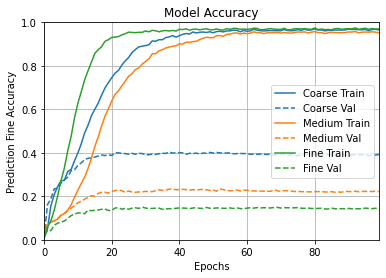

In [19]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

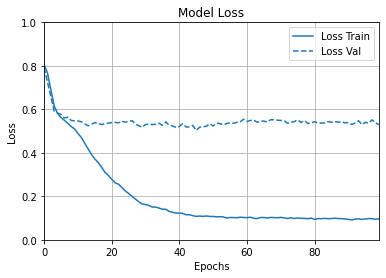

In [20]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [21]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

In [22]:
results = final_model.evaluate(test_dataset)
for n in range(len(results)):
    print(str(n+1)+'.',final_model.metrics_names[n], '==>', results[n])
model_predictions = final_model.predict(test_dataset)

182/182 [==============================] - 23s 116ms/step - loss: 0.5762 - prediction_coarse_loss: 0.5387 - prediction_medium_loss: 0.5866 - prediction_fine_loss: 0.6406 - prediction_coarse_accuracy: 0.3921 - prediction_medium_accuracy: 0.2220 - prediction_fine_accuracy: 0.1433
1. loss ==> 0.5761606693267822
2. prediction_coarse_loss ==> 0.5386728048324585
3. prediction_medium_loss ==> 0.5865850448608398
4. prediction_fine_loss ==> 0.6406316757202148
5. prediction_coarse_accuracy ==> 0.3921297788619995
6. prediction_medium_accuracy ==> 0.22195374965667725
7. prediction_fine_accuracy ==> 0.14325164258480072


In [23]:
def predict_from_pipeline(model, dataset):
    y_pred = []
    y_true = []
    for x, y in dataset:
        batch_pred = model.predict(x)
        for i in range(len(batch_pred)):
            if i >= len(y_pred):
                y_pred.append(None)
                y_true.append(None)
            if y_pred[i] is None:
                y_pred[i] = batch_pred[i]
                y_true[i] = list(y[i].numpy())
            else:
                y_pred[i] = np.concatenate([y_pred[i], batch_pred[i]])
                y_true[i] = y_true[i] + list(y[i].numpy())
    return y_true, y_pred

In [24]:
predictions = []
predictions.append(predict_from_pipeline(final_model, test_dataset))

In [25]:
dataset= {'y_test_coarse':predictions[0][0][0], 
          'y_test_medium':predictions[0][0][1], 
          'y_test_fine':predictions[0][0][2]}

In [26]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0][1][0],predictions[0][1][1],predictions[0][1][2]]

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 1  0  0 ...  0  0  0]
 [ 0 21  3 ...  0  0  0]
 [ 0  3 19 ...  0  1  0]
 ...
 [ 0  0  0 ... 14  6  0]
 [ 0  0  0 ...  1 50  2]
 [ 0  0  0 ...  0  5  5]]

  • MEDIUM LEVEL 
[[ 4  0  0 ...  0  0  0]
 [ 0  9  1 ...  0  1  0]
 [ 0  0  4 ...  0  0  0]
 ...
 [ 0  0  0 ... 33  0  1]
 [ 0  1  0 ...  0  9  0]
 [ 0  0  0 ...  3  0  4]]

  • FINE LEVEL 
[[1 0 1 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 7]]

  • Classification Report 


  • COARSE LEVEL 


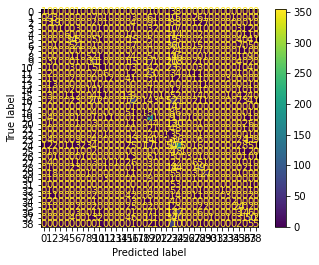

D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0    0.50000   0.07143   0.12500        14
           1    0.33871   0.31343   0.32558        67
           2    0.48718   0.28788   0.36190        66
           3    1.00000   0.02857   0.05556        35
           4    0.75000   0.20690   0.32432        29
           5    0.58621   0.34000   0.43038       100
           6    0.34426   0.18584   0.24138       113
           7    0.00000   0.00000   0.00000        15
           8    0.41667   0.08065   0.13514        62
           9    0.26957   0.26271   0.26609       118
          10    0.07692   0.01724   0.02817        58
          11    0.33333   0.12766   0.18462        47
          12    0.66667   0.08696   0.15385        23
          13    0.00000   0.00000   0.00000        12
          14    0.00000   0.00000   0.00000        12
          15    0.28889   0.19697   0.23423        66
          16    0.37895   0.36548   0.37209       197
          17    0.00000   0

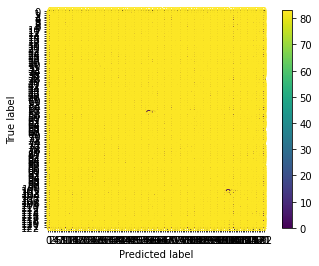

D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0    0.28571   0.20000   0.23529        20
           1    0.27273   0.33333   0.30000        27
           2    0.44444   0.36364   0.40000        11
           3    0.14286   0.11111   0.12500         9
           4    0.11111   0.07143   0.08696        14
           5    0.41176   0.16667   0.23729        42
           6    0.00000   0.00000   0.00000        13
           7    0.42857   0.40000   0.41379        15
           8    0.07692   0.06250   0.06897        16
           9    0.60000   0.37500   0.46154        16
          10    0.09091   0.06250   0.07407        16
          11    0.15000   0.37500   0.21429        16
          12    0.26471   0.25714   0.26087        35
          13    0.00000   0.00000   0.00000        17
          14    0.15385   0.22222   0.18182         9
          15    0.09091   0.04878   0.06349        41
          16    0.25000   0.20000   0.22222        10
          17    0.31250   0

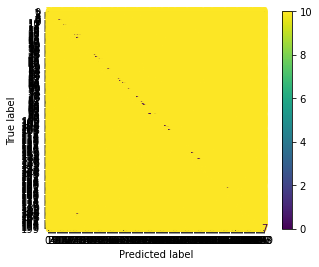

              precision    recall  f1-score   support

           0    0.14286   0.06667   0.09091        15
           1    0.16667   0.12500   0.14286        16
           2    0.08333   0.06250   0.07143        16
           3    0.00000   0.00000   0.00000        13
           4    0.09091   0.14286   0.11111         7
           5    0.00000   0.00000   0.00000         4
           6    0.28571   0.25000   0.26667        16
           7    0.09524   0.20000   0.12903        10
           8    0.18182   0.16667   0.17391        12
           9    0.23077   0.27273   0.25000        11
          10    0.00000   0.00000   0.00000        17
          11    0.39130   0.69231   0.50000        13
          12    0.26667   0.33333   0.29630        12
          13    0.05263   0.07692   0.06250        13
          14    0.00000   0.00000   0.00000        16
          15    0.45455   0.33333   0.38462        15
          16    0.16667   0.30000   0.21429        10
          17    0.05882   0

In [27]:
metrics.lvl_wise_metric(true_label,pred_label)

In [28]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,pred_label,tree)
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.237389253250489 
Hierarchical Recall = 0.2953630192152802 
Hierarchical F1-Score = 0.2593419026798385 
Consistency =  0.34380393510528134 
Exact Match =  0.08905764584052468
